# Prueba de datos

🔍 Buscando datos desde: c:\Users\Equipo\Desktop\Machine_DL...
✅ ¡ENCONTRADO!
📄 Archivo CSV: ..\petfinder-adoption-prediction\train\train.csv
📂 Carpeta base de datos: ..\petfinder-adoption-prediction

MASCOTA: Marley (ID: 1c6aa4b33)
Raza:    Poodle
Target:  2


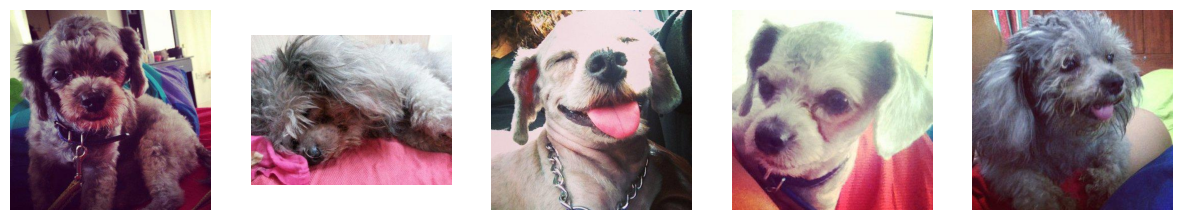

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

current_dir = os.getcwd()
search_start = ".." # Sube un nivel


print(f"🔍 Buscando datos desde: {os.path.abspath(search_start)}...")

train_path = None
root_data_folder = None

# Recorremos buscando 'train.csv'
for root, dirs, files in os.walk(search_start):
    if "train.csv" in files:
        train_path = os.path.join(root, "train.csv")
        if os.path.basename(root) == 'train':
            root_data_folder = os.path.dirname(root)
        else:
            root_data_folder = root
        
        print(f"✅ ¡ENCONTRADO!")
        print(f"📄 Archivo CSV: {train_path}")
        print(f"📂 Carpeta base de datos: {root_data_folder}")
        break

if not train_path:
    raise FileNotFoundError("❌ No se pudo localizar 'train.csv'. Asegúrate de que la carpeta 'petfinder-adoption-prediction' esté en Machine_DL.")


BREED_CSV_PATH = os.path.join(root_data_folder, 'breed_labels.csv')
COLOR_CSV_PATH = os.path.join(root_data_folder, 'color_labels.csv')
TRAIN_IMG_DIR  = os.path.join(root_data_folder, 'train_images') #


train = pd.read_csv(train_path)
breeds = pd.read_csv(BREED_CSV_PATH)
colors = pd.read_csv(COLOR_CSV_PATH)

# --- FUNCIONES DE APOYO ---
breed_dict = dict(zip(breeds['BreedID'], breeds['BreedName']))
def get_breed_name(breed_id):
    return breed_dict.get(breed_id, "Desconocido")

def visualizar_mascota(pet_id=None):
    if pet_id is None:
        pet_id = train.sample(1)['PetID'].values[0]
    
    pet_data = train[train['PetID'] == pet_id].iloc[0]
    
    print(f"\n{'='*40}")
    print(f"MASCOTA: {pet_data['Name']} (ID: {pet_id})")
    print(f"Raza:    {get_breed_name(pet_data['Breed1'])}")
    print(f"Target:  {pet_data['AdoptionSpeed']}")
    
    # Buscar imágenes en la carpeta detectada
    if os.path.exists(TRAIN_IMG_DIR):
        images = [f for f in os.listdir(TRAIN_IMG_DIR) if str(pet_id) in f and f.endswith('.jpg')]
        images.sort()
        
        if images:
            plt.figure(figsize=(15, 5))
            for i, img_file in enumerate(images[:5]):
                img_path = os.path.join(TRAIN_IMG_DIR, img_file)
                img = mpimg.imread(img_path)
                plt.subplot(1, 5, i + 1)
                plt.imshow(img)
                plt.axis('off')
            plt.show()
        else:
            print(">> No hay fotos para esta mascota.")
    else:
        print(f">> Carpeta de imágenes no encontrada en: {TRAIN_IMG_DIR}")

# ---EJECUTAR ---
visualizar_mascota()

# Estructura de datos y creación de un DataFrame

### Analisis del Dataset 

Primero analizamos el dataset de imagenes para la distribucion de las mismas y contemplar una posible reestructuración, ya sea de dimensiones, calidad o de número de imágenes, para que puedan ser procesadas correctamente.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import shutil
from sklearn.model_selection import train_test_split
from tqdm import tqdm  # Librería para ver barra de progreso

# ==========================================
# PARTE 1: LOCALIZACIÓN DE DATOS (Tu código original)
# ==========================================

current_dir = os.getcwd()
search_start = ".." # Sube un nivel

print(f"🔍 Buscando datos desde: {os.path.abspath(search_start)}...")

train_path = None
root_data_folder = None

# Recorremos buscando 'train.csv'
for root, dirs, files in os.walk(search_start):
    if "train.csv" in files:
        train_path = os.path.join(root, "train.csv")
        if os.path.basename(root) == 'train':
            root_data_folder = os.path.dirname(root)
        else:
            root_data_folder = root
        
        print(f"✅ ¡ENCONTRADO!")
        print(f"📄 Archivo CSV: {train_path}")
        print(f"📂 Carpeta base de datos: {root_data_folder}")
        break

if not train_path:
    raise FileNotFoundError("❌ No se pudo localizar 'train.csv'.")

BREED_CSV_PATH = os.path.join(root_data_folder, 'breed_labels.csv')
COLOR_CSV_PATH = os.path.join(root_data_folder, 'color_labels.csv')
TRAIN_IMG_DIR  = os.path.join(root_data_folder, 'train_images')

# Cargar datos
train = pd.read_csv(train_path)

# ==========================================
# PARTE 2: PREPARACIÓN Y DIVISIÓN DE DATOS
# ==========================================
print("\n📊 Preparando división de datos (Train / Test)...")

# Dividimos el CSV en Train (80%) y Test (20%) manteniendo la proporción de clases (AdoptionSpeed)
train_df, test_df = train_test_split(
    train, 
    test_size=0.2, 
    stratify=train['AdoptionSpeed'], 
    random_state=42
)

print(f"   -> Imágenes para Train: {len(train_df)}")
print(f"   -> Imágenes para Test:  {len(test_df)}")

# ==========================================
# PARTE 3: CREACIÓN DE ESTRUCTURA EN DRIVE
# ==========================================

# Tu ruta de destino en G:
base_nombre = 'datos tratados'
base_path_superior = os.path.join(r'G:\Mi unidad\Mascotas', base_nombre)

# Función optimizada para copiar
def copiar_imagenes_dataset(df, carpeta_destino_base, nombre_conjunto):
    print(f"\n🚀 Procesando conjunto: {nombre_conjunto} -> {carpeta_destino_base}")
    
    # Crear carpetas 0, 1, 2, 3, 4
    clases = ['0', '1', '2', '3', '4']
    for clase in clases:
        os.makedirs(os.path.join(carpeta_destino_base, clase), exist_ok=True)
    
    copiadas = 0
    faltantes = 0
    
    # Iteramos con barra de progreso
    for _, row in tqdm(df.iterrows(), total=len(df), unit="mascota"):
        pet_id = row['PetID']
        adop_speed = str(row['AdoptionSpeed'])
        
        # En PetFinder, una mascota puede tener varias fotos: PetID-1.jpg, PetID-2.jpg...
        # Buscamos patrones que empiecen por el PetID
        # NOTA: Esto asume que tienes las imágenes descomprimidas en TRAIN_IMG_DIR
        
        # Estrategia rápida: Intentar copiar la foto 1 (la principal)
        # Si quieres TODAS las fotos, el código se complica un poco más buscando archivos, 
        # pero para entrenar modelos, a veces basta con la primera o las primeras 3.
        # Aquí intentaremos copiar TODAS las que existan secuencialmente.
        
        encontro_alguna = False
        for i in range(1, 10): # Busca foto -1, -2 ... hasta -9
            nombre_foto = f"{pet_id}-{i}.jpg"
            ruta_origen = os.path.join(TRAIN_IMG_DIR, nombre_foto)
            
            if os.path.exists(ruta_origen):
                ruta_destino = os.path.join(carpeta_destino_base, adop_speed, nombre_foto)
                
                # Copiar solo si no existe ya
                if not os.path.exists(ruta_destino):
                    shutil.copy2(ruta_origen, ruta_destino)
                
                copiadas += 1
                encontro_alguna = True
            else:
                # Si no existe la -1, es raro, pero si no existe la -3 dejamos de buscar para esta mascota
                if i == 1: 
                    pass # La foto principal falta
                else: 
                    break # Se acabaron las fotos de esta mascota
        
        if not encontro_alguna:
            faltantes += 1

    print(f"✅ Finalizado {nombre_conjunto}: {copiadas} fotos copiadas. ({faltantes} mascotas sin fotos)")

# --- EJECUCIÓN DE LA COPIA ---

if os.path.exists(TRAIN_IMG_DIR):
    # Crear rutas de destino
    train_dest = os.path.join(base_path_superior, 'Train')
    test_dest = os.path.join(base_path_superior, 'Test')

    # Ejecutar
    copiar_imagenes_dataset(train_df, train_dest, "TRAIN")
    copiar_imagenes_dataset(test_df, test_dest, "TEST")
    
    print(f"\n✨ ¡Proceso completo! Revisa tu carpeta en: {base_path_superior}")
else:
    print(f"❌ ERROR CRÍTICO: No encuentro la carpeta de imágenes origen en: {TRAIN_IMG_DIR}")
    print("Asegúrate de haber descomprimido el archivo train_images.zip de Kaggle en esa carpeta.")

🔍 Buscando datos desde: c:\Users\Equipo\Desktop\Machine_DL...
✅ ¡ENCONTRADO!
📄 Archivo CSV: ..\petfinder-adoption-prediction\train\train.csv
📂 Carpeta base de datos: ..\petfinder-adoption-prediction

📊 Preparando división de datos (Train / Test)...
   -> Imágenes para Train: 11994
   -> Imágenes para Test:  2999

🚀 Procesando conjunto: TRAIN -> G:\Mi unidad\Mascotas\datos tratados\Train


100%|██████████| 11994/11994 [2:49:32<00:00,  1.18mascota/s]  


✅ Finalizado TRAIN: 42840 fotos copiadas. (273 mascotas sin fotos)

🚀 Procesando conjunto: TEST -> G:\Mi unidad\Mascotas\datos tratados\Test


100%|██████████| 2999/2999 [18:47<00:00,  2.66mascota/s]  

✅ Finalizado TEST: 10702 fotos copiadas. (68 mascotas sin fotos)

✨ ¡Proceso completo! Revisa tu carpeta en: G:\Mi unidad\Mascotas\datos tratados


✅ Analizando datos en: c:\Users\Equipo\Desktop\Machine_DL\datos tratados


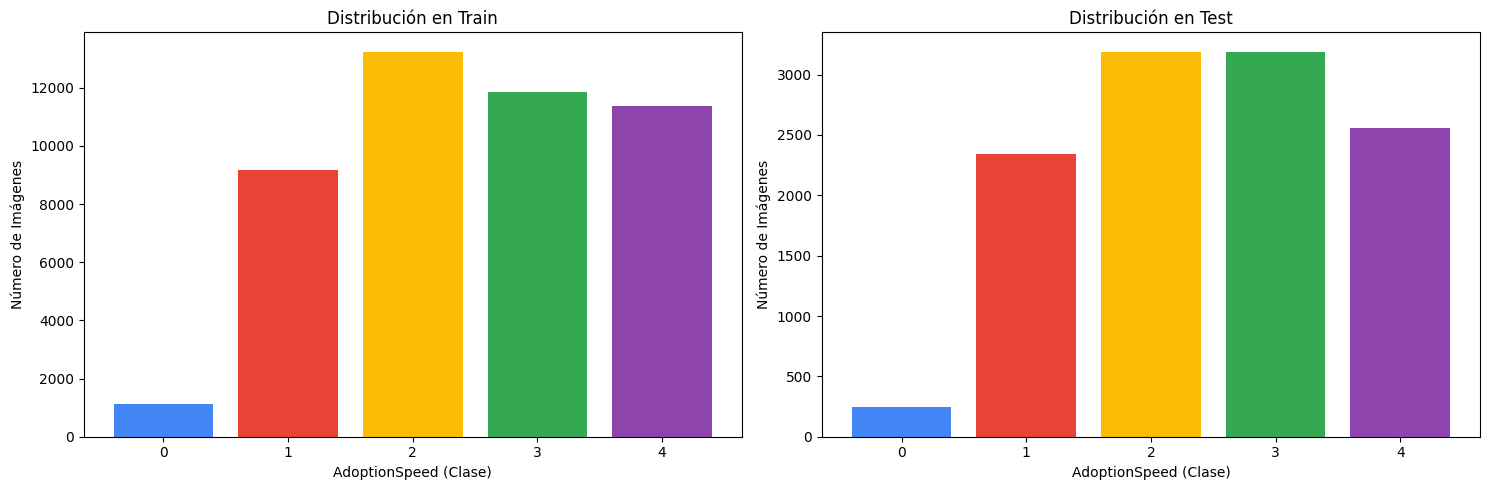

In [ ]:
import matplotlib.pyplot as plt
import os
import seaborn as sns # Añadimos seaborn para que los gráficos se vean más modernos

def graficar_distribucion(nombre_carpeta='datos tratados'):
    # 1. Detección de ruta
    if os.path.exists(nombre_carpeta):
        base_path = nombre_carpeta
    elif os.path.exists(os.path.join(r'G:\Mi unidad\Mascotas', nombre_carpeta)):
        base_path = os.path.join(r'G:\Mi unidad\Mascotas', nombre_carpeta) 
    else:
        print(f"❌ No se encuentra la carpeta '{nombre_carpeta}'")
        return

    print(f"✅ Analizando datos en: {os.path.abspath(base_path)}")

    sets = ['Train', 'Test']
    clases = ['0', '1', '2', '3', '4']
    colores = ['#4285F4', '#EA4335', '#FBBC05', '#34A853', '#8E44AD']
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 6)) # Un poco más alto para que quepan los números
    
    for i, s in enumerate(sets):
        counts = []
        for c in clases:
            path = os.path.join(base_path, s, c)
            if os.path.exists(path):
                # Solo contamos archivos, no carpetas
                counts.append(len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]))
            else:
                counts.append(0)
        
        bars = ax[i].bar(clases, counts, color=colores, edgecolor='black', alpha=0.8)
        ax[i].set_title(f'Distribución en {s}', fontsize=14, fontweight='bold')
        ax[i].set_xlabel('AdoptionSpeed (Clase)', fontsize=12)
        ax[i].set_ylabel('Número de Imágenes', fontsize=12)
        ax[i].grid(axis='y', linestyle='--', alpha=0.6)
        
        # Añadir el número total encima de cada barra
        for bar in bars:
            height = bar.get_height()
            ax[i].annotate(f'{height}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 puntos de offset vertical
                        textcoords="offset points",
                        ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

graficar_distribucion()

🔍 Analizando subcarpetas en: G:\Mi unidad\Mascotas\datos tratados\Train
📁 Procesando clase 0 (1045 imágenes)...


100%|██████████| 1045/1045 [00:09<00:00, 107.57it/s]


📁 Procesando clase 1 (8672 imágenes)...


100%|██████████| 8672/8672 [01:26<00:00, 100.63it/s]


📁 Procesando clase 2 (12145 imágenes)...


100%|██████████| 12145/12145 [02:09<00:00, 93.83it/s] 


📁 Procesando clase 3 (10614 imágenes)...


100%|██████████| 10614/10614 [01:27<00:00, 121.66it/s]


📁 Procesando clase 4 (10364 imágenes)...


100%|██████████| 10364/10364 [01:40<00:00, 103.42it/s]


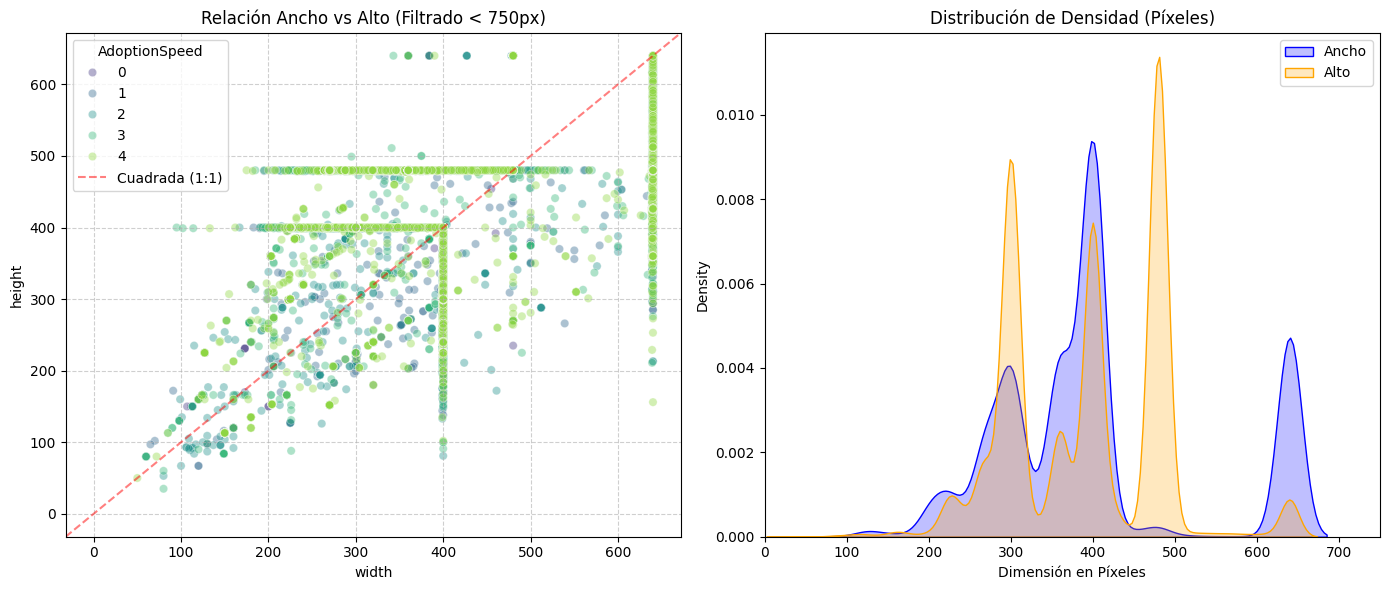


📊 Resumen de Resoluciones (Sin Outliers):
              width        height
count  42839.000000  42839.000000
mean     399.001704    390.319172
std      126.332044     93.350147
min       50.000000     35.000000
25%      300.000000    300.000000
50%      400.000000    400.000000
75%      400.000000    480.000000
max      640.000000    640.000000

📏 Relación de aspecto media: 1.07

📈 Imágenes analizadas por clase:
class
0     1045
1     8672
2    12145
3    10614
4    10363
Name: count, dtype: int64


In [27]:
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm # Importante para ver el progreso en Drive

# --- 1. CONFIGURACIÓN DE RUTAS ---
# Apuntamos a la base de datos tratada en Drive
directorio = r'G:\Mi unidad\Mascotas\datos tratados\Train'

if not os.path.exists(directorio):
    print(f"❌ Error: No se encuentra la carpeta en {os.path.abspath(directorio)}")
    raise FileNotFoundError

print(f"🔍 Analizando subcarpetas en: {os.path.abspath(directorio)}")

# --- 2. RECOLECCIÓN RECURSIVA DE DIMENSIONES ---
resoluciones = []

# Usamos os.walk para entrar en las carpetas 0, 1, 2, 3, 4
for root, dirs, files in os.walk(directorio):
    # Filtramos solo archivos JPG
    fotos = [f for f in files if f.lower().endswith(('.jpg', '.jpeg'))]
    
    if fotos:
        print(f"📁 Procesando clase {os.path.basename(root)} ({len(fotos)} imágenes)...")
        for archivo in tqdm(fotos):
            path_completo = os.path.join(root, archivo)
            try:
                # PIL.Image.open no carga la imagen entera en memoria, solo lee la cabecera
                with Image.open(path_completo) as img:
                    ancho, alto = img.size
                    resoluciones.append({
                        'width': ancho, 
                        'height': alto, 
                        'class': os.path.basename(root)
                    })
            except:
                continue

# Creamos el DataFrame
df_res = pd.DataFrame(resoluciones)

if df_res.empty:
    print("❌ No se encontraron imágenes. Verifica las rutas.")
else:
    # --- 3. FILTRO DE OUTLIERS (Límite 750px) ---
    df_res = df_res[(df_res['width'] <= 750) & (df_res['height'] <= 750)]

    # --- 4. VISUALIZACIÓN GRÁFICA ---
    plt.figure(figsize=(14, 6))

    # Subplot 1: Distribución Conjunta por Clase
    plt.subplot(1, 2, 1)
    sns.scatterplot(data=df_res, x='width', y='height', hue='class', alpha=0.4, palette='viridis')
    plt.title('Relación Ancho vs Alto (Filtrado < 750px)')
    plt.axline((0, 0), slope=1, color='red', linestyle='--', alpha=0.5, label='Cuadrada (1:1)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title='AdoptionSpeed')

    # Subplot 2: Histogramas de densidad
    plt.subplot(1, 2, 2)
    sns.kdeplot(data=df_res, x='width', fill=True, color='blue', label='Ancho')
    sns.kdeplot(data=df_res, x='height', fill=True, color='orange', label='Alto')
    plt.title('Distribución de Densidad (Píxeles)')
    plt.xlabel('Dimensión en Píxeles')
    plt.xlim(0, 750)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # --- 5. ESTADÍSTICAS ---
    print("\n📊 Resumen de Resoluciones (Sin Outliers):")
    print(df_res[['width', 'height']].describe())

    df_res['aspect_ratio'] = df_res['width'] / df_res['height']
    print(f"\n📏 Relación de aspecto media: {df_res['aspect_ratio'].mean():.2f}")
    
    # Conteo por clase para verificar balance
    print("\n📈 Imágenes analizadas por clase:")
    print(df_res['class'].value_counts().sort_index())

Definimos una posible forma de data augmentation para nuestro dataset. Por ahora no la vamos a usar ya que no es necesario.

## Reestructuración del Dataset

Después de analizar el dataset, se ha decidido reestructurarlo para que sea más fácil de manejar y para que sea más fácil de entrenar el modelo. Creamos una carpeta llamada reestructured_dataset que contiene las imágenes reescaladas a 400x400.

In [40]:
import os
import shutil
import random
from glob import glob
from tqdm import tqdm

# --- 1. CONFIGURACIÓN DE RUTAS EN DRIVE ---
BASE_DRIVE_ROUTE = r'G:\Mi unidad\Mascotas'
SOURCE_DIR = os.path.join(BASE_DRIVE_ROUTE, 'datos tratados', 'Train')
TARGET_DIR = os.path.join(BASE_DRIVE_ROUTE, 'mini_dataset')

CLASSES = ['0', '1', '2', '3', '4']

# Nuevos porcentajes solicitados
TRAIN_PCT = 0.15  # 5%
TEST_PCT = 0.15  # 15%

# 2. LIMPIEZA Y PREPARACIÓN
if os.path.exists(TARGET_DIR):
    print(f'🧹 Eliminando mini_dataset antiguo en: {TARGET_DIR}...')
    shutil.rmtree(TARGET_DIR)

# Creamos las carpetas de destino
TRAIN_TARGET = os.path.join(TARGET_DIR, 'Train')
TEST_TARGET = os.path.join(TARGET_DIR, 'Test')

for folder in [TRAIN_TARGET, TEST_TARGET]:
    for cls in CLASSES:
        os.makedirs(os.path.join(folder, cls), exist_ok=True)

# 3. CÁLCULO DE BALANCEO
class_counts = {}
for cls in CLASSES:
    cls_path = os.path.join(SOURCE_DIR, cls)
    if os.path.exists(cls_path):
        imgs = glob(os.path.join(cls_path, '*.*'))
        class_counts[cls] = len(imgs)
    else:
        class_counts[cls] = 0

# Buscamos la clase con menos imágenes para que el dataset sea perfectamente simétrico
min_class_available = min(class_counts.values())

# Calculamos cuántas imágenes van a cada set por clase
n_train_per_class = int(min_class_available * TRAIN_PCT)
n_test_per_class = int(min_class_available * TEST_PCT)

# Aseguramos un mínimo de 1 imagen si los porcentajes son muy bajos
n_train_per_class = max(1, n_train_per_class)
n_test_per_class = max(1, n_test_per_class)

print(f'📊 Clase limitante: {min_class_available} imágenes.')
print(f'🎯 Por clase: {n_train_per_class} para Train, {n_test_per_class} para Test.')
print(f'📦 Total imágenes: {(n_train_per_class + n_test_per_class) * 5}')

# 4. PROCESO DE SELECCIÓN Y COPIADO
for cls in CLASSES:
    src_cls_dir = os.path.join(SOURCE_DIR, cls)
    all_images = glob(os.path.join(src_cls_dir, '*.*'))
    
    # Seleccionamos un pool total para evitar que una imagen esté en ambos sets (Data Leakage)
    total_to_pick = n_train_per_class + n_test_per_class
    selection = random.sample(all_images, total_to_pick)
    
    # Dividimos la selección
    train_pool = selection[:n_train_per_class]
    test_pool = selection[n_train_per_class:]
    
    print(f'\n🚀 Copiando Clase {cls}...')
    
    # Copiar a Train
    for img in tqdm(train_pool, desc=f"  Train {cls}"):
        shutil.copy(img, os.path.join(TRAIN_TARGET, cls))
        
    # Copiar a Test
    for img in tqdm(test_pool, desc=f"  Test  {cls}"):
        shutil.copy(img, os.path.join(TEST_TARGET, cls))
            
print(f'\n✨ Proceso completado con éxito.')
print(f'📂 Ubicación: {TARGET_DIR}')

🧹 Eliminando mini_dataset antiguo en: G:\Mi unidad\Mascotas\mini_dataset...
📊 Clase limitante: 1045 imágenes.
🎯 Por clase: 156 para Train, 156 para Test.
📦 Total imágenes: 1560

🚀 Copiando Clase 0...


  Test  0: 100%|██████████| 156/156 [00:09<00:00, 15.65it/s]



🚀 Copiando Clase 1...


  Test  1: 100%|██████████| 156/156 [00:09<00:00, 16.88it/s]



🚀 Copiando Clase 2...


  Test  2: 100%|██████████| 156/156 [00:11<00:00, 13.55it/s]



🚀 Copiando Clase 3...


  Test  3: 100%|██████████| 156/156 [00:11<00:00, 13.32it/s]



🚀 Copiando Clase 4...


  Test  4: 100%|██████████| 156/156 [00:11<00:00, 13.09it/s]


✨ Proceso completado con éxito.
📂 Ubicación: G:\Mi unidad\Mascotas\mini_dataset


# Implementacion de una red neuronal desde 0


In [5]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, cohen_kappa_score
# import numpy as np
# import os
# import seaborn as sns

# # 1. Configuracion Inicial
# SEED = 42
# torch.manual_seed(SEED)
# np.random.seed(SEED)
# BATCH_SIZE = 32
# EPOCHS = 10
# LR = 0.001
# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f'Usando dispositivo: {DEVICE}')

# # 2. Preparacion de Datos
# transform = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.ToTensor(),
# ])

# # Rutas relativas desde el notebook
# base_dir = os.path.dirname(os.path.abspath('__file__')) if '__file__' in locals() else os.getcwd()
# train_dir = os.path.join(base_dir, '..', 'mini_dataset')
# test_dir = os.path.join(base_dir, '..', 'reestructured_dataset', 'Test')

# if os.path.exists(train_dir) and os.path.exists(test_dir):
#     train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
#     test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
    
#     train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
#     test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
#     print(f'Clases encontradas: {train_dataset.classes}')
# else:
#     print('Error: No se encuentran los directorios de datos.')
#     print(f'Buscado en: {train_dir} y {test_dir}')

# # 3. Definicion del Modelo (Simple CNN)
# class SimpleCNN(nn.Module):
#     def __init__(self, num_classes=5):
#         super(SimpleCNN, self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
#             nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
#             nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2)
#         )
#         self.classifier = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(64*16*16, 128), nn.ReLU(), nn.Dropout(0.5),
#             nn.Linear(128, num_classes)
#         )
#     def forward(self, x):
#         return self.classifier(self.features(x))

# model = SimpleCNN(num_classes=5).to(DEVICE)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=LR)

# # 4. Entrenamiento
# train_losses = []
# print('Iniciando entrenamiento...')
# for epoch in range(EPOCHS):
#     model.train()
#     running_loss = 0.0
#     for images, labels in train_loader:
#         images, labels = images.to(DEVICE), labels.to(DEVICE)
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()
#     epoch_loss = running_loss / len(train_loader)
#     train_losses.append(epoch_loss)
#     print(f'Epoch {epoch+1}/{EPOCHS} - Loss: {epoch_loss:.4f}')

# # Graficar Loss
# plt.figure(figsize=(10, 5))
# plt.plot(train_losses, label='Training Loss')
# plt.title('Evolucion del Loss')
# plt.xlabel('Epoca')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# # 5. Evaluacion
# print('Evaluando modelo...')
# model.eval()
# all_preds = []
# all_labels = []
# with torch.no_grad():
#     for images, labels in test_loader:
#         images, labels = images.to(DEVICE), labels.to(DEVICE)
#         outputs = model(images)
#         _, preds = torch.max(outputs, 1)
#         all_preds.extend(preds.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())

# # Metricas
# accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
# qwk = cohen_kappa_score(all_labels, all_preds, weights='quadratic')
# print(f'Accuracy: {accuracy:.4f}')
# print(f'Quadratic Weighted Kappa (QWK): {qwk:.4f}')

# # Matriz de Confusion
# cm = confusion_matrix(all_labels, all_preds)
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
# plt.title('Matriz de Confusion')
# plt.ylabel('Clase Real')
# plt.xlabel('Clase Predicha')
# plt.show()

# # Limpieza de memoria
# del model
# if 'torch' in locals(): torch.cuda.empty_cache()


🚀 Iniciando entrenamiento con Transfer Learning...


Entrenando: 100%|██████████| 2678/2678 [11:42<00:00,  3.81it/s]


Época 1/10 - Pérdida: 1.7913


Entrenando: 100%|██████████| 2678/2678 [11:14<00:00,  3.97it/s]


Época 2/10 - Pérdida: 1.7518


Entrenando: 100%|██████████| 2678/2678 [11:19<00:00,  3.94it/s]


Época 3/10 - Pérdida: 1.7259


Entrenando: 100%|██████████| 2678/2678 [11:11<00:00,  3.99it/s]


Época 4/10 - Pérdida: 1.7102


Entrenando: 100%|██████████| 2678/2678 [11:17<00:00,  3.95it/s]


Época 5/10 - Pérdida: 1.6912


Entrenando: 100%|██████████| 2678/2678 [11:18<00:00,  3.95it/s]


Época 6/10 - Pérdida: 1.6751


Entrenando: 100%|██████████| 2678/2678 [11:25<00:00,  3.91it/s]


Época 7/10 - Pérdida: 1.6576


Entrenando: 100%|██████████| 2678/2678 [11:24<00:00,  3.91it/s]


Época 8/10 - Pérdida: 1.6412


Entrenando: 100%|██████████| 2678/2678 [11:19<00:00,  3.94it/s]


Época 9/10 - Pérdida: 1.6160


Entrenando: 100%|██████████| 2678/2678 [11:17<00:00,  3.95it/s]


Época 10/10 - Pérdida: 1.6031

✅ QWK Final con Transfer Learning: 0.2445


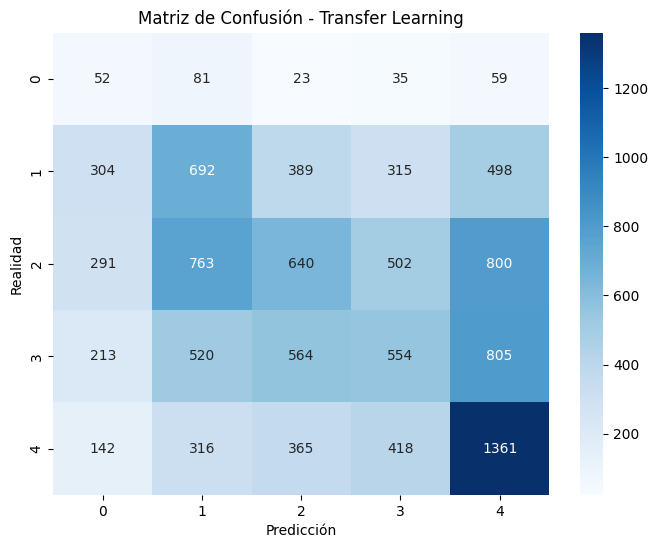

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os
import seaborn as sns

# Configuración de hiperparámetros
# Aumentamos el batch size para que el gradiente sea más estable
SEED = 42
torch.manual_seed(SEED)
BATCH_SIZE = 16 
EPOCHS = 10
LR = 0.0001 # Un learning rate más bajo ayuda en Transfer Learning
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Directorios de datos según la estructura del proyecto
base_datos_drive = r'G:\Mi unidad\Mascotas\datos tratados'
train_dir = os.path.join(base_datos_drive, 'Train')
test_dir = os.path.join(base_datos_drive, 'Test')

# Transformaciones optimizadas
# Reducimos un poco el tamaño a 224x224 para ResNet y eficiencia
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Carga de datos
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform_test)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Cálculo de pesos para clases desbalanceadas
targets = train_dataset.targets
weights = compute_class_weight('balanced', classes=np.unique(targets), y=targets)
weights = torch.tensor(weights, dtype=torch.float).to(DEVICE)

# Arquitectura 1: CNN desde Cero (Simple para evitar overfitting)
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

# Arquitectura 2: Transfer Learning (ResNet50)
def get_transfer_model(num_classes=5):
    # Cargamos pesos pre-entrenados de ImageNet
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    # Congelamos las primeras capas para no destruir lo aprendido en ImageNet
    for param in model.parameters():
        param.requires_grad = False
    # Reemplazamos la última capa (fc) por una nueva para nuestras 5 categorías
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, num_classes)
    )
    return model

# Función de pérdida avanzada para problemas ordinales (PetFinder)
class OrdinalLoss(nn.Module):
    def __init__(self, weights):
        super().__init__()
        self.ce = nn.CrossEntropyLoss(weight=weights)
    
    def forward(self, outputs, targets):
        # Cross Entropy estándar
        loss_ce = self.ce(outputs, targets)
        # Penalización por distancia (si predice 4 y era 0, duele más que predecir 1)
        probs = F.softmax(outputs, dim=1)
        idx = torch.arange(outputs.size(1)).to(DEVICE).float()
        pred_mean = torch.sum(probs * idx, dim=1)
        loss_dist = F.mse_loss(pred_mean, targets.float())
        return loss_ce + 0.2 * loss_dist

# Bucle de entrenamiento simplificado
def train_model(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(loader, desc="Entrenando"):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

# Evaluación y cálculo de QWK
def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    qwk = cohen_kappa_score(all_labels, all_preds, weights='quadratic')
    return qwk, all_labels, all_preds

# --- EJECUCIÓN ---
# Probamos el modelo de Transfer Learning que es el que subirá el QWK
model = get_transfer_model().to(DEVICE)
criterion = OrdinalLoss(weights=weights)
optimizer = optim.Adam(model.fc.parameters(), lr=LR)

print("🚀 Iniciando entrenamiento con Transfer Learning...")
for epoch in range(EPOCHS):
    train_loss = train_model(model, train_loader, criterion, optimizer)
    print(f"Época {epoch+1}/{EPOCHS} - Pérdida: {train_loss:.4f}")

qwk_final, labels, preds = evaluate_model(model, test_loader)
print(f"\n✅ QWK Final con Transfer Learning: {qwk_final:.4f}")

# Matriz de confusión para diagnóstico
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title('Matriz de Confusión - Transfer Learning')
plt.show()

🚀 Iniciando entrenamiento con Transfer Learning...


Entrenando: 100%|██████████| 857/857 [29:47<00:00,  2.09s/it]


Época 1/5 - Pérdida: 1.8087


Entrenando: 100%|██████████| 857/857 [21:44<00:00,  1.52s/it]


Época 2/5 - Pérdida: 1.7621


Entrenando: 100%|██████████| 857/857 [23:35<00:00,  1.65s/it]


Época 3/5 - Pérdida: 1.7345


Entrenando: 100%|██████████| 857/857 [21:57<00:00,  1.54s/it]


Época 4/5 - Pérdida: 1.7157


Entrenando: 100%|██████████| 857/857 [11:28<00:00,  1.24it/s]


Época 5/5 - Pérdida: 1.6903

✅ QWK: 0.2368


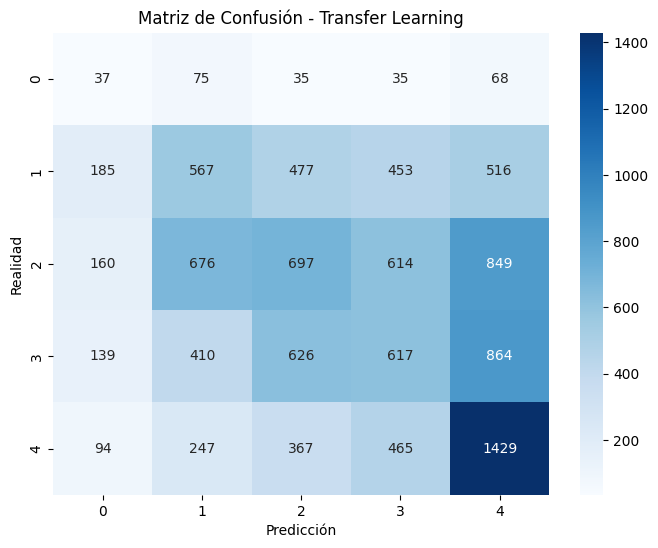

In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os
import seaborn as sns

# Configuración de hiperparámetros
# Aumentamos el batch size para que el gradiente sea más estable
SEED = 42
torch.manual_seed(SEED)
BATCH_SIZE = 50 #16
EPOCHS = 5
LR = 0.0001 # Un learning rate más bajo ayuda en Transfer Learning
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Directorios de datos según la estructura del proyecto
base_datos_drive = r'G:\Mi unidad\Mascotas\datos tratados'
train_dir = os.path.join(base_datos_drive, 'Train')
test_dir = os.path.join(base_datos_drive, 'Test')

# Transformaciones optimizadas
# Reducimos un poco el tamaño a 224x224 para ResNet y eficiencia
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Carga de datos
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform_test)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Cálculo de pesos para clases desbalanceadas
targets = train_dataset.targets
weights = compute_class_weight('balanced', classes=np.unique(targets), y=targets)
weights = torch.tensor(weights, dtype=torch.float).to(DEVICE)

# Arquitectura 1: CNN desde Cero (Simple para evitar overfitting)
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

# Arquitectura 2: Transfer Learning (ResNet50)
def get_transfer_model(num_classes=5):
    # Cargamos pesos pre-entrenados de ImageNet
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    # Congelamos las primeras capas para no destruir lo aprendido en ImageNet
    for param in model.parameters():
        param.requires_grad = False
    # Reemplazamos la última capa (fc) por una nueva para nuestras 5 categorías
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, num_classes)
    )
    return model

# Función de pérdida avanzada para problemas ordinales (PetFinder)
class OrdinalLoss(nn.Module):
    def __init__(self, weights):
        super().__init__()
        self.ce = nn.CrossEntropyLoss(weight=weights)
    
    def forward(self, outputs, targets):
        # Cross Entropy estándar
        loss_ce = self.ce(outputs, targets)
        # Penalización por distancia (si predice 4 y era 0, duele más que predecir 1)
        probs = F.softmax(outputs, dim=1)
        idx = torch.arange(outputs.size(1)).to(DEVICE).float()
        pred_mean = torch.sum(probs * idx, dim=1)
        loss_dist = F.mse_loss(pred_mean, targets.float())
        return loss_ce + 0.2 * loss_dist

# Bucle de entrenamiento simplificado
def train_model(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(loader, desc="Entrenando"):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

# Evaluación y cálculo de QWK
def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    qwk = cohen_kappa_score(all_labels, all_preds, weights='quadratic')
    return qwk, all_labels, all_preds

# --- EJECUCIÓN ---
# Probamos el modelo de Transfer Learning que es el que subirá el QWK
model = get_transfer_model().to(DEVICE)
criterion = OrdinalLoss(weights=weights)
optimizer = optim.Adam(model.fc.parameters(), lr=LR)

print("🚀 Iniciando entrenamiento con Transfer Learning...")
for epoch in range(EPOCHS):
    train_loss = train_model(model, train_loader, criterion, optimizer)
    print(f"Época {epoch+1}/{EPOCHS} - Pérdida: {train_loss:.4f}")

qwk_final, labels, preds = evaluate_model(model, test_loader)
print(f"\n✅ QWK: {qwk_final:.4f}")

# Matriz de confusión para diagnóstico
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title('Matriz de Confusión - Transfer Learning')
plt.show()

🚀 Iniciando entrenamiento con Transfer Learning...


Entrenando: 100%|██████████| 5355/5355 [11:52<00:00,  7.52it/s]


Época 1/10 - Pérdida: 1.7731


Entrenando: 100%|██████████| 5355/5355 [11:33<00:00,  7.72it/s]


Época 2/10 - Pérdida: 1.7444


Entrenando: 100%|██████████| 5355/5355 [11:48<00:00,  7.56it/s]


Época 3/10 - Pérdida: 1.7207


Entrenando: 100%|██████████| 5355/5355 [12:12<00:00,  7.31it/s]


Época 4/10 - Pérdida: 1.7109


Entrenando: 100%|██████████| 5355/5355 [11:43<00:00,  7.61it/s]


Época 5/10 - Pérdida: 1.7003


Entrenando: 100%|██████████| 5355/5355 [11:35<00:00,  7.69it/s]


Época 6/10 - Pérdida: 1.6866


Entrenando: 100%|██████████| 5355/5355 [12:39<00:00,  7.05it/s]


Época 7/10 - Pérdida: 1.6750


Entrenando: 100%|██████████| 5355/5355 [12:00<00:00,  7.43it/s]


Época 8/10 - Pérdida: 1.6641


Entrenando: 100%|██████████| 5355/5355 [11:43<00:00,  7.62it/s]


Época 9/10 - Pérdida: 1.6479


Entrenando: 100%|██████████| 5355/5355 [11:39<00:00,  7.66it/s]


Época 10/10 - Pérdida: 1.6418

✅ QWK: 0.2384


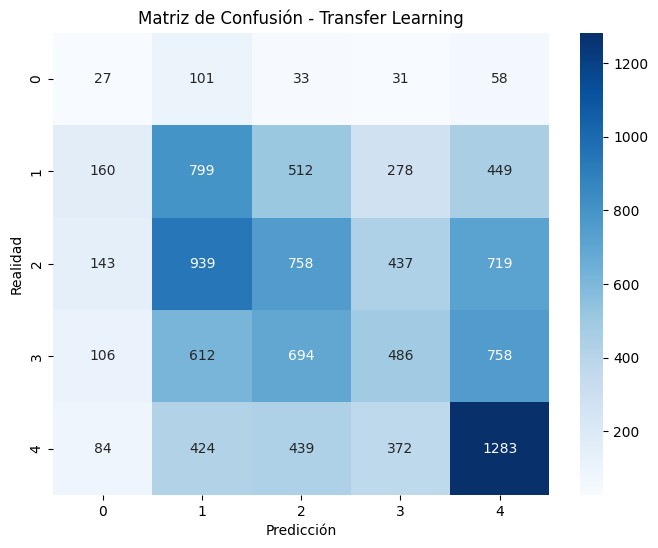

In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os
import seaborn as sns

# Configuración de hiperparámetros
# Aumentamos el batch size para que el gradiente sea más estable
SEED = 42
torch.manual_seed(SEED)
BATCH_SIZE = 8 #16
EPOCHS = 10
LR = 0.0001 # Un learning rate más bajo ayuda en Transfer Learning
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Directorios de datos según la estructura del proyecto
base_datos_drive = r'G:\Mi unidad\Mascotas\datos tratados'
train_dir = os.path.join(base_datos_drive, 'Train')
test_dir = os.path.join(base_datos_drive, 'Test')

# Transformaciones optimizadas
# Reducimos un poco el tamaño a 224x224 para ResNet y eficiencia
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Carga de datos
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform_test)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Cálculo de pesos para clases desbalanceadas
targets = train_dataset.targets
weights = compute_class_weight('balanced', classes=np.unique(targets), y=targets)
weights = torch.tensor(weights, dtype=torch.float).to(DEVICE)

# Arquitectura 1: CNN desde Cero (Simple para evitar overfitting)
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

# Arquitectura 2: Transfer Learning (ResNet50)
def get_transfer_model(num_classes=5):
    # Cargamos pesos pre-entrenados de ImageNet
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    # Congelamos las primeras capas para no destruir lo aprendido en ImageNet
    for param in model.parameters():
        param.requires_grad = False
    # Reemplazamos la última capa (fc) por una nueva para nuestras 5 categorías
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, num_classes)
    )
    return model

# Función de pérdida avanzada para problemas ordinales (PetFinder)
class OrdinalLoss(nn.Module):
    def __init__(self, weights):
        super().__init__()
        self.ce = nn.CrossEntropyLoss(weight=weights)
    
    def forward(self, outputs, targets):
        # Cross Entropy estándar
        loss_ce = self.ce(outputs, targets)
        # Penalización por distancia (si predice 4 y era 0, duele más que predecir 1)
        probs = F.softmax(outputs, dim=1)
        idx = torch.arange(outputs.size(1)).to(DEVICE).float()
        pred_mean = torch.sum(probs * idx, dim=1)
        loss_dist = F.mse_loss(pred_mean, targets.float())
        return loss_ce + 0.2 * loss_dist

# Bucle de entrenamiento simplificado
def train_model(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(loader, desc="Entrenando"):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

# Evaluación y cálculo de QWK
def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    qwk = cohen_kappa_score(all_labels, all_preds, weights='quadratic')
    return qwk, all_labels, all_preds

# --- EJECUCIÓN ---
# Probamos el modelo de Transfer Learning que es el que subirá el QWK
model = get_transfer_model().to(DEVICE)
criterion = OrdinalLoss(weights=weights)
optimizer = optim.Adam(model.fc.parameters(), lr=LR)

print("🚀 Iniciando entrenamiento con Transfer Learning...")
for epoch in range(EPOCHS):
    train_loss = train_model(model, train_loader, criterion, optimizer)
    print(f"Época {epoch+1}/{EPOCHS} - Pérdida: {train_loss:.4f}")

qwk_final, labels, preds = evaluate_model(model, test_loader)
print(f"\n✅ QWK: {qwk_final:.4f}")

# Matriz de confusión para diagnóstico
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title('Matriz de Confusión - Transfer Learning')
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os
import seaborn as sns

# Aumentamos el batch size para que el gradiente sea más estable
SEED = 42
torch.manual_seed(SEED)
BATCH_SIZE = 16 
EPOCHS = 50
LR = 0.0001 # Un learning rate más bajo ayuda en Transfer Learning
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Directorios de datos según la estructura del proyecto
base_datos_drive = r'G:\Mi unidad\Mascotas\datos tratados'
train_dir = os.path.join(base_datos_drive, 'Train')
test_dir = os.path.join(base_datos_drive, 'Test')

# Transformaciones optimizadas
# Reducimos un poco el tamaño a 224x224 para ResNet y eficiencia
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Carga de datos con persistencia
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform_test)

# Importante: num_workers=0 suele evitar el OSError en Google Drive Desktop (Windows)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Pesos de clase
targets = train_dataset.targets
weights = compute_class_weight('balanced', classes=np.unique(targets), y=targets)
weights = torch.tensor(weights, dtype=torch.float).to(DEVICE)

# Arquitectura 1: CNN desde Cero (Simple para evitar overfitting)
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

# Arquitectura 2: Transfer Learning (ResNet50)
def get_transfer_model(num_classes=5):
    # Cargamos pesos pre-entrenados de ImageNet
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    # Congelamos las primeras capas para no destruir lo aprendido en ImageNet
    for param in model.parameters():
        param.requires_grad = False
    # Reemplazamos la última capa (fc) por una nueva para nuestras 5 categorías
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, num_classes)
    )
    return model

# Función de pérdida avanzada para problemas ordinales (PetFinder)
class OrdinalLoss(nn.Module):
    def __init__(self, weights):
        super().__init__()
        self.ce = nn.CrossEntropyLoss(weight=weights)
    
    def forward(self, outputs, targets):
        # Cross Entropy estándar
        loss_ce = self.ce(outputs, targets)
        # Penalización por distancia (si predice 4 y era 0, duele más que predecir 1)
        probs = F.softmax(outputs, dim=1)
        idx = torch.arange(outputs.size(1)).to(DEVICE).float()
        pred_mean = torch.sum(probs * idx, dim=1)
        loss_dist = F.mse_loss(pred_mean, targets.float())
        return loss_ce + 0.2 * loss_dist

# Bucle de entrenamiento simplificado
def train_model(model, loader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(loader, desc=f"Época {epoch+1}/{EPOCHS}"):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Guardamos checkpoint al final de cada época
    torch.save(model.state_dict(), 'checkpoint_petfinder.pth')
    return running_loss / len(loader)

# Evaluación y cálculo de QWK
def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    qwk = cohen_kappa_score(all_labels, all_preds, weights='quadratic')
    return qwk, all_labels, all_preds

# --- EJECUCIÓN ---
# Probamos el modelo de Transfer Learning que es el que subirá el QWK
model = get_transfer_model().to(DEVICE)
criterion = OrdinalLoss(weights=weights)
optimizer = optim.Adam(model.fc.parameters(), lr=LR)

print("🚀 Iniciando entrenamiento con Transfer Learning...")
for epoch in range(EPOCHS):
    train_loss = train_model(model, train_loader, criterion, optimizer)
    print(f"Época {epoch+1}/{EPOCHS} - Pérdida: {train_loss:.4f}")

qwk_final, labels, preds = evaluate_model(model, test_loader)
print(f"\n✅ QWK: {qwk_final:.4f}")

# Matriz de confusión para diagnóstico
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title('Matriz de Confusión - Transfer Learning')
plt.show()

🚀 Iniciando entrenamiento con Transfer Learning...


Entrenando: 100%|██████████| 2678/2678 [11:16<00:00,  3.96it/s]


Época 1/50 - Pérdida: 1.7913


Entrenando: 100%|██████████| 2678/2678 [11:01<00:00,  4.05it/s]


Época 2/50 - Pérdida: 1.7518


Entrenando: 100%|██████████| 2678/2678 [11:05<00:00,  4.03it/s]


Época 3/50 - Pérdida: 1.7259


Entrenando: 100%|██████████| 2678/2678 [11:01<00:00,  4.05it/s]


Época 4/50 - Pérdida: 1.7102


Entrenando: 100%|██████████| 2678/2678 [10:55<00:00,  4.09it/s]


Época 5/50 - Pérdida: 1.6912


Entrenando: 100%|██████████| 2678/2678 [11:04<00:00,  4.03it/s]


Época 6/50 - Pérdida: 1.6751


Entrenando: 100%|██████████| 2678/2678 [10:55<00:00,  4.08it/s]


Época 7/50 - Pérdida: 1.6576


Entrenando: 100%|██████████| 2678/2678 [10:59<00:00,  4.06it/s]


Época 8/50 - Pérdida: 1.6412


Entrenando: 100%|██████████| 2678/2678 [11:32<00:00,  3.87it/s]


Época 9/50 - Pérdida: 1.6160


Entrenando: 100%|██████████| 2678/2678 [11:17<00:00,  3.95it/s]


Época 10/50 - Pérdida: 1.6031


Entrenando: 100%|██████████| 2678/2678 [10:59<00:00,  4.06it/s]


Época 11/50 - Pérdida: 1.5915


Entrenando: 100%|██████████| 2678/2678 [10:55<00:00,  4.08it/s]


Época 12/50 - Pérdida: 1.5670


Entrenando: 100%|██████████| 2678/2678 [10:57<00:00,  4.07it/s]


Época 13/50 - Pérdida: 1.5519


Entrenando: 100%|██████████| 2678/2678 [10:56<00:00,  4.08it/s]


Época 14/50 - Pérdida: 1.5401


Entrenando: 100%|██████████| 2678/2678 [10:59<00:00,  4.06it/s]


Época 15/50 - Pérdida: 1.5307


Entrenando: 100%|██████████| 2678/2678 [11:01<00:00,  4.05it/s]


Época 16/50 - Pérdida: 1.5051


Entrenando: 100%|██████████| 2678/2678 [10:56<00:00,  4.08it/s]


Época 17/50 - Pérdida: 1.4920


Entrenando: 100%|██████████| 2678/2678 [10:58<00:00,  4.06it/s]


Época 18/50 - Pérdida: 1.4734


Entrenando: 100%|██████████| 2678/2678 [10:57<00:00,  4.07it/s]


Época 19/50 - Pérdida: 1.4683


Entrenando: 100%|██████████| 2678/2678 [10:58<00:00,  4.07it/s]


Época 20/50 - Pérdida: 1.4510


Entrenando: 100%|██████████| 2678/2678 [10:56<00:00,  4.08it/s]


Época 21/50 - Pérdida: 1.4384


Entrenando: 100%|██████████| 2678/2678 [11:02<00:00,  4.04it/s]


Época 22/50 - Pérdida: 1.4190


Entrenando: 100%|██████████| 2678/2678 [10:57<00:00,  4.07it/s]


Época 23/50 - Pérdida: 1.4122


Entrenando: 100%|██████████| 2678/2678 [10:54<00:00,  4.09it/s]


Época 24/50 - Pérdida: 1.3929


Entrenando: 100%|██████████| 2678/2678 [10:55<00:00,  4.08it/s]


Época 25/50 - Pérdida: 1.3799


Entrenando: 100%|██████████| 2678/2678 [10:58<00:00,  4.07it/s]


Época 26/50 - Pérdida: 1.3772


Entrenando: 100%|██████████| 2678/2678 [11:00<00:00,  4.05it/s]


Época 27/50 - Pérdida: 1.3608


Entrenando: 100%|██████████| 2678/2678 [10:58<00:00,  4.07it/s]


Época 28/50 - Pérdida: 1.3461


Entrenando: 100%|██████████| 2678/2678 [10:55<00:00,  4.08it/s]


Época 29/50 - Pérdida: 1.3416


Entrenando: 100%|██████████| 2678/2678 [10:53<00:00,  4.10it/s]


Época 30/50 - Pérdida: 1.3298


Entrenando: 100%|██████████| 2678/2678 [10:57<00:00,  4.07it/s]


Época 31/50 - Pérdida: 1.3109


Entrenando: 100%|██████████| 2678/2678 [11:00<00:00,  4.05it/s]


Época 32/50 - Pérdida: 1.3031


Entrenando: 100%|██████████| 2678/2678 [11:03<00:00,  4.04it/s]


Época 33/50 - Pérdida: 1.2916


Entrenando: 100%|██████████| 2678/2678 [10:57<00:00,  4.08it/s]


Época 34/50 - Pérdida: 1.2825


Entrenando: 100%|██████████| 2678/2678 [10:56<00:00,  4.08it/s]


Época 35/50 - Pérdida: 1.2780


Entrenando: 100%|██████████| 2678/2678 [10:57<00:00,  4.07it/s]


Época 36/50 - Pérdida: 1.2701


Entrenando: 100%|██████████| 2678/2678 [11:00<00:00,  4.05it/s]


Época 37/50 - Pérdida: 1.2543


Entrenando: 100%|██████████| 2678/2678 [11:11<00:00,  3.99it/s]


Época 38/50 - Pérdida: 1.2498


Entrenando: 100%|██████████| 2678/2678 [10:56<00:00,  4.08it/s]


Época 39/50 - Pérdida: 1.2390


Entrenando: 100%|██████████| 2678/2678 [11:07<00:00,  4.01it/s]


Época 40/50 - Pérdida: 1.2350


Entrenando: 100%|██████████| 2678/2678 [10:59<00:00,  4.06it/s]


Época 41/50 - Pérdida: 1.2319


Entrenando: 100%|██████████| 2678/2678 [11:02<00:00,  4.04it/s]


Época 42/50 - Pérdida: 1.2125


Entrenando: 100%|██████████| 2678/2678 [10:54<00:00,  4.09it/s]


Época 43/50 - Pérdida: 1.2147


Entrenando: 100%|██████████| 2678/2678 [10:56<00:00,  4.08it/s]


Época 44/50 - Pérdida: 1.2024


Entrenando: 100%|██████████| 2678/2678 [10:53<00:00,  4.10it/s]


Época 45/50 - Pérdida: 1.2028


Entrenando: 100%|██████████| 2678/2678 [10:52<00:00,  4.10it/s]


Época 46/50 - Pérdida: 1.1928


Entrenando: 100%|██████████| 2678/2678 [10:54<00:00,  4.09it/s]


Época 47/50 - Pérdida: 1.1885


Entrenando: 100%|██████████| 2678/2678 [10:52<00:00,  4.11it/s]


Época 48/50 - Pérdida: 1.1780


Entrenando: 100%|██████████| 2678/2678 [10:55<00:00,  4.09it/s]


Época 49/50 - Pérdida: 1.1661


Entrenando:  76%|███████▌  | 2025/2678 [08:13<02:39,  4.11it/s]


OSError: [Errno 22] Invalid argument

Intentando evaluar con el modelo actual en memoria...
------------------------------
✅ QWK (Métrica Ordinal): 0.2457
✅ Accuracy Global: 0.3275 (32.75%)
------------------------------


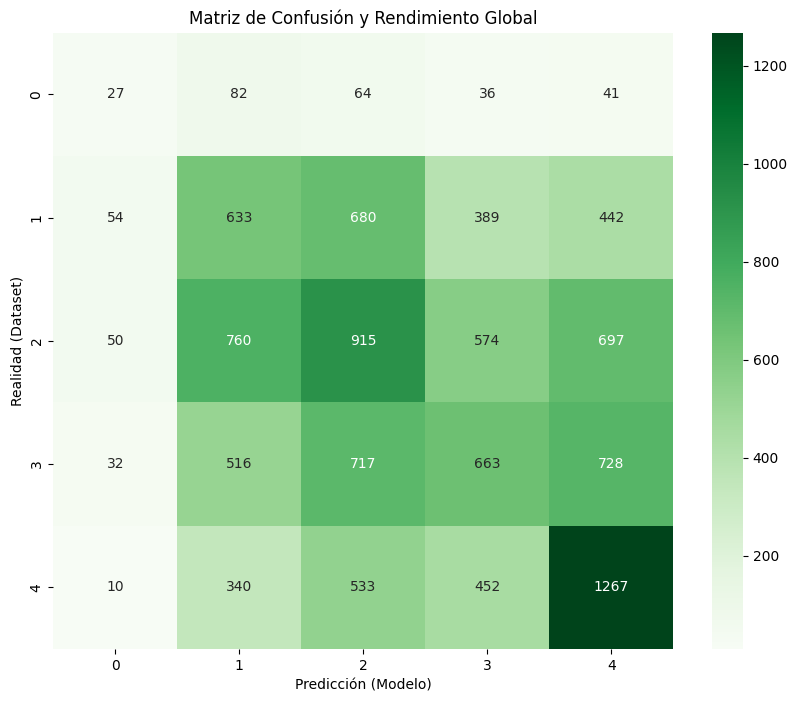

In [58]:
from sklearn.metrics import accuracy_score

try:
    print("Intentando evaluar con el modelo actual en memoria...")
    
    # Obtenemos las etiquetas reales y las predicciones
    qwk_final, labels, preds = evaluate_model(model, test_loader)
    
    # Calculamos el Accuracy Global
    acc_global = accuracy_score(labels, preds)
    
    # Mostramos los resultados principales
    print("-" * 30)
    print(f"✅ QWK (Métrica Ordinal): {qwk_final:.4f}")
    print(f"✅ Accuracy Global: {acc_global:.4f} ({acc_global*100:.2f}%)")
    print("-" * 30)

    # Matriz de Confusión para el análisis visual
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Greens', 
        xticklabels=train_dataset.classes, 
        yticklabels=train_dataset.classes
    )
    
    plt.xlabel('Predicción (Modelo)')
    plt.ylabel('Realidad (Dataset)')
    plt.title('Matriz de Confusión y Rendimiento Global')
    plt.show()

except NameError:
    print("❌ Error: El modelo o los datos no están cargados en la memoria actual.")
    print("Asegúrate de haber ejecutado las celdas de definición de funciones y carga de datos.")